In [2]:
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange
from torch import nn, einsum, Tensor

import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import io
import itertools

from reni.utils.utils import find_nerfstudio_project_root, rot_z, rot_y
from reni.field_components.vn_layers import VNInvariant, VNLinear, VNReLU

import plotly.graph_objects as go

def get_3d_vector_plot(latent_code, vectors_to_show, seed=42, axis_size=2):
    """
    Plots a subset of 3D vectors from the latent code using Matplotlib and returns the plot as an image array.
    The quivers are colored with a repeatable set of colors.

    :param latent_code: torch.tensor -> [N, 3]
    :param vectors_to_show: int
    """

    random.seed(seed)

    # Define a list of colors
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan']
    color_cycle = itertools.cycle(colors)

    fixed_arrowhead_size = 0.2  # Adjust this value as needed

    # Ensure the latent code is a 2D tensor with shape [N, 3]
    if len(latent_code.shape) != 2 or latent_code.shape[1] != 3:
        raise ValueError("latent_code must be a 2D tensor with shape [N, 3]")

    # Ensure vectors_to_show is not greater than the number of vectors in latent_code
    vectors_to_show = min(vectors_to_show, latent_code.shape[0])

    # Select a random subset of vectors
    indices = random.sample(range(latent_code.shape[0]), vectors_to_show)
    vectors = latent_code[indices]

    # Initialize 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Add vectors to the plot
    for vector in vectors:
        vector = vector.cpu().numpy()  # Convert tensor to numpy array
        length = np.linalg.norm(vector)  # Calculate the length of the vector

        if length > 2:
            # Normalise the vector to length 2
            vector = (vector / length) * 2
            length = 2

        # Adjust arrow_length_ratio to maintain consistent arrowhead size
        arrow_length_ratio = fixed_arrowhead_size / length

        # Plot the vector with a color from the color cycle
        color = next(color_cycle)
        ax.quiver(0, 0, 0, vector[0], vector[1], vector[2], color=color, length=length, 
                  normalize=True, arrow_length_ratio=arrow_length_ratio)

    # Setting the ticks on each axis
    ax.set_xticks([-axis_size, 0, axis_size])
    ax.set_yticks([-axis_size, 0, axis_size])
    ax.set_zticks([-axis_size, 0, axis_size])

    # set axis labels as x, y and z
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # remove grid
    ax.grid(False)

    # Save the plot to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    img_array = np.array(img)
    buf.close()

    plt.close(fig)  # Close the figure to free up memory

    img_array = img_array[30:410, 20:395, :3]

    return img_array

In [3]:
equivariance = "SO2"
axis_of_invariance = 2 # z-axis

Z = torch.randn(1, 10, 3)  # [1, latent_dim, 3]
D = torch.randn(1, 3)  # [1, 3]

rotation = rot_z(torch.deg2rad(torch.tensor(90.0)))

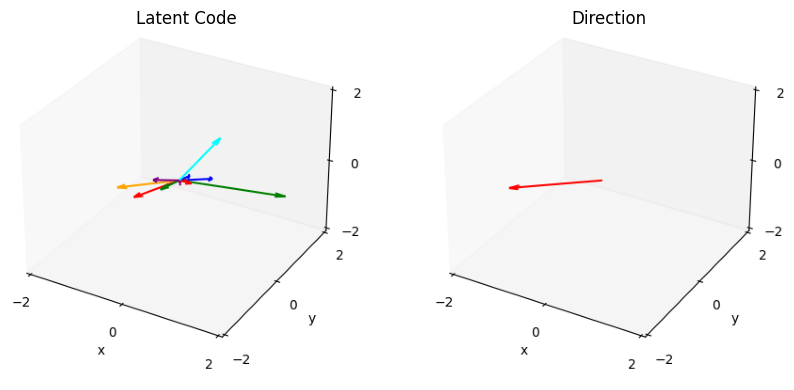

In [4]:
# plot the latent code and the direction side by side
latent_img = get_3d_vector_plot(Z[0], 10)
direction_img = get_3d_vector_plot(D[0].unsqueeze(0), 1)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.imshow(latent_img)
ax1.axis('off')
ax1.set_title("Latent Code")

ax2 = fig.add_subplot(122)
ax2.imshow(direction_img)
ax2.axis('off')
ax2.set_title("Direction")

plt.show()


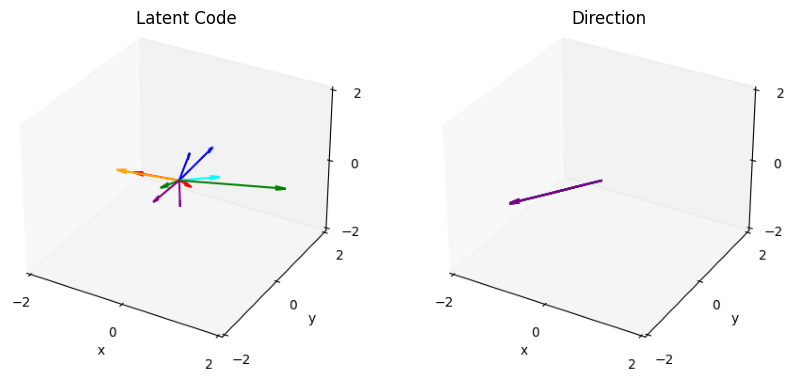

In [5]:
assert 0 <= axis_of_invariance < 3, "axis_of_invariance should be 0, 1, or 2."
other_axes = [i for i in range(3) if i != axis_of_invariance]

z_other = torch.stack((Z[:, :, other_axes[0]], Z[:, :, other_axes[1]]), -1)  # [num_rays, latent_dim, 2]
d_other = torch.stack((D[:, other_axes[0]], D[:, other_axes[1]]), -1).unsqueeze(1)  # [num_rays, 2]
d_other = d_other.expand_as(z_other)  # size becomes [num_rays, latent_dim, 2]

# in order to plot in 3d we need to add the z-axis back but with zeros
z_other_expand = torch.cat((z_other, torch.zeros_like(z_other[..., :1])), -1)  # [num_rays, latent_dim, 3]
d_other_expand = torch.cat((d_other, torch.zeros_like(d_other[..., :1])), -1)  # [num_rays, latent_dim, 3]

# plot z_other and d_other side by side
latent_img = get_3d_vector_plot(z_other_expand[0], 10)
direction_img = get_3d_vector_plot(d_other_expand[0], 10)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.imshow(latent_img)
ax1.axis('off')
ax1.set_title("Latent Code")

ax2 = fig.add_subplot(122)
ax2.imshow(direction_img)
ax2.axis('off')
ax2.set_title("Direction")

plt.show()


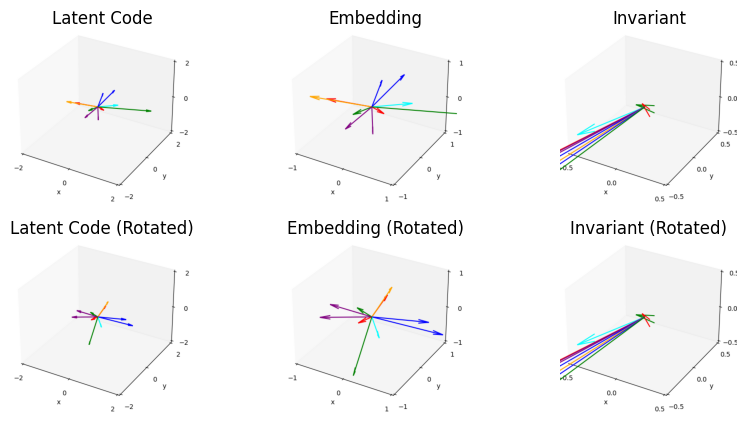

In [6]:
vn_proj_in = nn.Sequential(
    Rearrange("... c -> ... 1 c"), VNLinear(dim_in=1, dim_out=1, bias_epsilon=0)
)
dim_coor = 2 if equivariance == "SO2" else 3
vn_invar = VNInvariant(dim=1, dim_coor=dim_coor)

# z_other_emb = vn_proj_in(z_other)  # [num_rays, latent_dim, 1, 2]
z_other_emb = z_other.unsqueeze(2)  # [num_rays, latent_dim, 1, 2]
z_other_invar = vn_invar(z_other_emb)  # [num_rays, latent_dim, 2]

# add the z-axis back but with zeros
z_other_emb = torch.cat((z_other_emb, torch.zeros_like(z_other_emb[..., :1])), -1)  # [num_rays, latent_dim, 1, 3] # linear projection with expanded dim
z_other_invar = torch.cat((z_other_invar, torch.zeros_like(z_other_invar[..., :1])), -1)  # [num_rays, latent_dim, 3]

# plot z_other, z_other_emb and z_other_invar side by side
latent_img = get_3d_vector_plot(z_other_expand[0], 10)
embedding_img = get_3d_vector_plot(z_other_emb[0, :, 0, :].detach(), 10, axis_size=1)
invariant_img = get_3d_vector_plot(z_other_invar[0].detach(), 10, axis_size=0.5)

Z_rot = torch.matmul(Z, rotation)
z_rot_other = torch.stack((Z_rot[:, :, other_axes[0]], Z_rot[:, :, other_axes[1]]), -1)  # [num_rays, latent_dim, 2]
z_rot_other_expand = torch.cat((z_rot_other, torch.zeros_like(z_rot_other[..., :1])), -1)  # [num_rays, latent_dim, 3]

# z_rot_other_emb = vn_proj_in(z_rot_other)  # [num_rays, latent_dim, 1, 2]
z_rot_other_emb = z_rot_other.unsqueeze(2)  # [num_rays, latent_dim, 1, 2]
z_rot_other_invar = vn_invar(z_rot_other_emb)  # [num_rays, latent_dim, 2]

z_rot_other_emb = torch.cat((z_rot_other_emb, torch.zeros_like(z_rot_other_emb[..., :1])), -1)  # [num_rays, latent_dim, 1, 3] # linear projection with expanded dim
z_rot_other_invar = torch.cat((z_rot_other_invar, torch.zeros_like(z_rot_other_invar[..., :1])), -1)  # [num_rays, latent_dim, 3]

# plot z_other, z_other_emb and z_other_invar side by side
latent_rot_img = get_3d_vector_plot(z_rot_other_expand[0], 10)
embedding_rot_img = get_3d_vector_plot(z_rot_other_emb[0, :, 0, :].detach(), 10, axis_size=1)
invariant_rot_img = get_3d_vector_plot(z_rot_other_invar[0].detach(), 10, axis_size=0.5)

# plot first row unrotated and second row rotated
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(231)
ax1.imshow(latent_img)
ax1.axis('off')
ax1.set_title("Latent Code")

ax2 = fig.add_subplot(232)
ax2.imshow(embedding_img)
ax2.axis('off')
ax2.set_title("Embedding")

ax3 = fig.add_subplot(233)
ax3.imshow(invariant_img)
ax3.axis('off')
ax3.set_title("Invariant")

ax4 = fig.add_subplot(234)
ax4.imshow(latent_rot_img)
ax4.axis('off')
ax4.set_title("Latent Code (Rotated)")

ax5 = fig.add_subplot(235)
ax5.imshow(embedding_rot_img)
ax5.axis('off')
ax5.set_title("Embedding (Rotated)")

ax6 = fig.add_subplot(236)
ax6.imshow(invariant_rot_img)
ax6.axis('off')
ax6.set_title("Invariant (Rotated)")

plt.show()

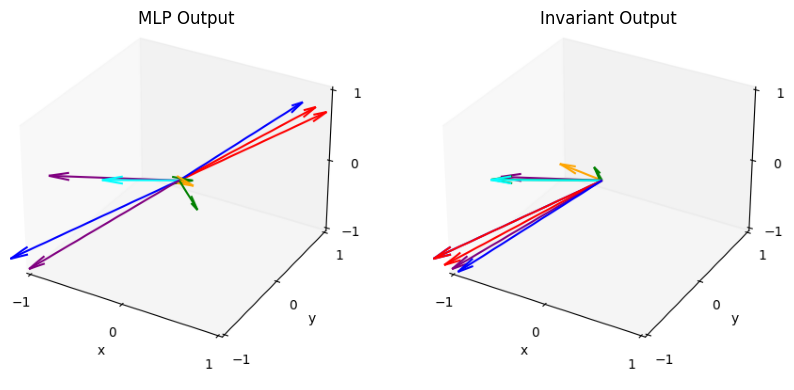

In [146]:
# delving deeper into invariant layer:
mlp = nn.Sequential(
    VNLinear(1, 2),
    VNReLU(2),
    Rearrange('... d e -> ... e d')
)

# z_other_emb.shape = [num_rays, latent_dim, 1, 2] B, N, C, 2
mlp_out = mlp(z_other_emb) # [num_rays, latent_dim, 3, 2] # coordinate system T in R^3x2 B

out = einsum('b n d i, b n i o -> b n o', z_other_emb, mlp_out) # [num_rays, latent_dim, 2] # read z in T?

mlp_out_expand = torch.cat((mlp_out, torch.zeros_like(mlp_out[..., :1])), -1) 
out_expand = torch.cat((out, torch.zeros_like(out[..., :1])), -1)  # [num_rays, latent_dim, 3]

# plot mlp_out_expand and out_expand side by side

mlp_out_img = get_3d_vector_plot(mlp_out_expand[0, :, 0, :].detach(), 10, axis_size=1)
out_img = get_3d_vector_plot(out_expand[0].detach(), 10, axis_size=1)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.imshow(mlp_out_img)
ax1.axis('off')
ax1.set_title("MLP Output")

ax2 = fig.add_subplot(122)
ax2.imshow(out_img)
ax2.axis('off')
ax2.set_title("Invariant Output")

plt.show()

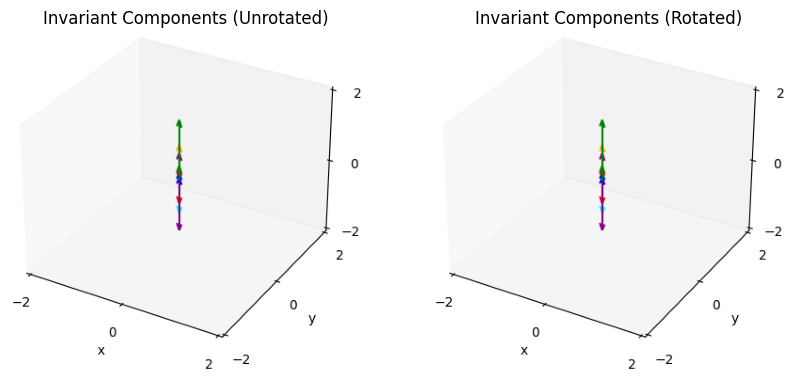

In [123]:
# Get invariant component of Z along the axis of invariance
z_invar = Z[:, :, axis_of_invariance].unsqueeze(-1)  # [num_rays, latent_dim, 1]

# set x and y to zero
z_invar_expand = torch.cat((torch.zeros_like(z_invar), torch.zeros_like(z_invar), z_invar), -1)  # [num_rays, latent_dim, 3]

z_invar_rot = Z_rot[:, :, axis_of_invariance].unsqueeze(-1)  # [num_rays, latent_dim, 1]
z_invar_rot_expand = torch.cat((torch.zeros_like(z_invar_rot), torch.zeros_like(z_invar_rot), z_invar_rot), -1)  # [num_rays, latent_dim, 3]

# plot z_invar and z_invar_rot side by side
z_img = get_3d_vector_plot(z_invar_expand[0], 10)
z_rot_img = get_3d_vector_plot(z_invar_rot_expand[0], 10)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.imshow(z_img)
ax1.axis('off')
ax1.set_title("Invariant Components (Unrotated)")

ax2 = fig.add_subplot(122)
ax2.imshow(z_rot_img)
ax2.axis('off')
ax2.set_title("Invariant Components (Rotated)")

plt.show()

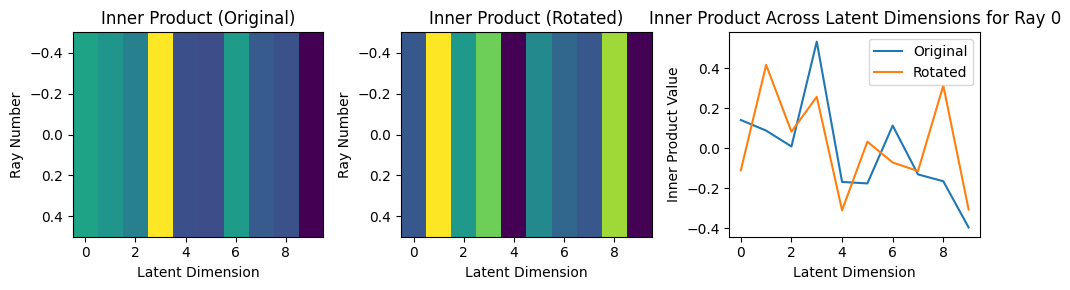

In [106]:
# Innerproduct between projection of Z and D on the plane orthogonal to the axis of invariance.
# This encodes the rotational information. This is rotation-equivariant to rotations of either Z
# or D and is invariant to rotations of both Z and D.
# z_other.shape = [num_rays, latent_dim, 2]
# d_other.shape = [num_rays, latent_dim, 2]
# z_rot_other.shape = [num_rays, latent_dim, 2]
innerprod = (z_other * d_other).sum(dim=-1)  # [num_rays, latent_dim]

innerprod_rot = (z_rot_other * d_other).sum(dim=-1)  # [num_rays, latent_dim]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Heatmap of innerprod
axes[0].imshow(innerprod, cmap='viridis', aspect='auto')
axes[0].set_title('Inner Product (Original)')
axes[0].set_xlabel('Latent Dimension')
axes[0].set_ylabel('Ray Number')

# Heatmap of innerprod_rot
axes[1].imshow(innerprod_rot, cmap='viridis', aspect='auto')
axes[1].set_title('Inner Product (Rotated)')
axes[1].set_xlabel('Latent Dimension')
axes[1].set_ylabel('Ray Number')

# Line plot for a specific ray
ray_index = 0  # Example ray index
axes[2].plot(innerprod[ray_index, :], label='Original')
axes[2].plot(innerprod_rot[ray_index, :], label='Rotated')
axes[2].set_title(f'Inner Product Across Latent Dimensions for Ray {ray_index}')
axes[2].set_xlabel('Latent Dimension')
axes[2].set_ylabel('Inner Product Value')
axes[2].legend()

plt.tight_layout()
plt.show()

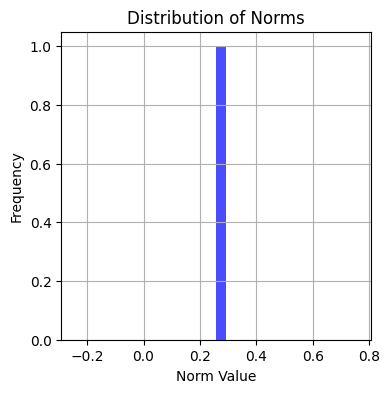

In [114]:
# Compute norm along the axes orthogonal to the axis of invariance
d_other_norm = torch.sqrt(D[::, other_axes[0]] ** 2 + D[:, other_axes[1]] ** 2).unsqueeze(
    -1
)  # [num_rays, 1]

# Plotting
plt.figure(figsize=(4, 4))
plt.hist(d_other_norm, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Norms')
plt.xlabel('Norm Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


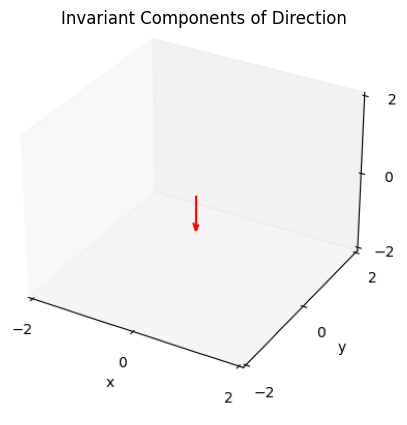

In [121]:
# Get invariant component of D along the axis of invariance
d_invar = D[:, axis_of_invariance].unsqueeze(-1)  # [num_rays, 1]

d_invar_expand = torch.cat((torch.zeros_like(d_invar), torch.zeros_like(d_invar), d_invar), -1)  # [num_rays, 3]

# Plotting
d_img = get_3d_vector_plot(d_invar_expand, 1)
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)
ax1.imshow(d_img)
ax1.axis('off')
ax1.set_title("Invariant Components of Direction")

plt.show()

In [ ]:
directional_input = torch.cat((innerprod, d_invar, d_other_norm), 1)  # [num_rays, latent_dim + 2]

In [ ]:
conditioning_input = torch.cat((z_other_invar, z_invar), dim=-1).flatten(1)  # [num_rays, latent_dim * 3]